In [1]:
import pandas as pd
from load_ulg import load_ulg, timeframe
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, HuberRegressor
import scipy
model_name = "x500"
if model_name == 'x500':
    from geometry import x500 as model
else:
    from geometry import race6 as model
from process import throttle_thrust, find_tau, fit_tau, plot_thrust_curve, torque_angular_acceleration, plot_torque_angular_acceleration_curve
import numpy as np

In [2]:
if model_name == "x500":
    output_topic = "actuator_motors_mux" # use "actuator_controls" for the unmodified PX4
else:
    output_topic = "actuator_motors" # use "actuator_controls" for the unmodified PX4

### Loading the logfile into a Pandas dataframe

In [3]:
if model_name == 'x500':
    ulog_files = [
        # "logs/test.ulg",
        # "logs/test2.ulg"
        "logs/2023-12-27-x500/log_36_2023-12-27-14-21-32.ulg",
        "logs/2023-12-27-x500/log_37_2023-12-27-14-24-24.ulg"
    ]
else:
    ulog_files = [
        "logs/2023-12-13-nishanth-sysid/log_45_2023-12-13-21-07-46-up-and-down.ulg",
        "logs/2023-12-14-yang-crash/log_60_2023-12-14-20-26-16.ulg"
    ]
dfs = [load_ulg(file) for file in ulog_files]

### Exploring the datapoints in the dataframe

In [4]:
grep = "actuator_motors"
[col for col in dfs[0].columns if grep in col]

['actuator_motors_timestamp',
 'actuator_motors_control[0]',
 'actuator_motors_control[1]',
 'actuator_motors_control[2]',
 'actuator_motors_control[3]',
 'actuator_motors_control[4]',
 'actuator_motors_control[5]',
 'actuator_motors_control[6]',
 'actuator_motors_control[7]',
 'actuator_motors_control[8]',
 'actuator_motors_control[9]',
 'actuator_motors_control[10]',
 'actuator_motors_control[11]',
 'actuator_motors_reversible_flags',
 'actuator_motors_mux_timestamp',
 'actuator_motors_mux_control[0]',
 'actuator_motors_mux_control[1]',
 'actuator_motors_mux_control[2]',
 'actuator_motors_mux_control[3]',
 'actuator_motors_mux_control[4]',
 'actuator_motors_mux_control[5]',
 'actuator_motors_mux_control[6]',
 'actuator_motors_mux_control[7]',
 'actuator_motors_mux_control[8]',
 'actuator_motors_mux_control[9]',
 'actuator_motors_mux_control[10]',
 'actuator_motors_mux_control[11]',
 'actuator_motors_mux_reversible_flags',
 'actuator_motors_rl_tools_timestamp',
 'actuator_motors_rl_to

### Looking at the outputs to find the relevant timeframe

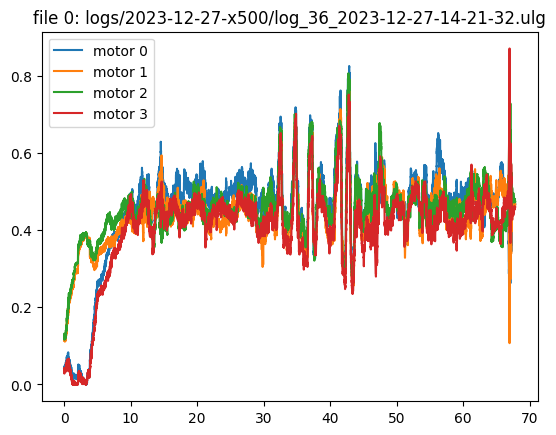

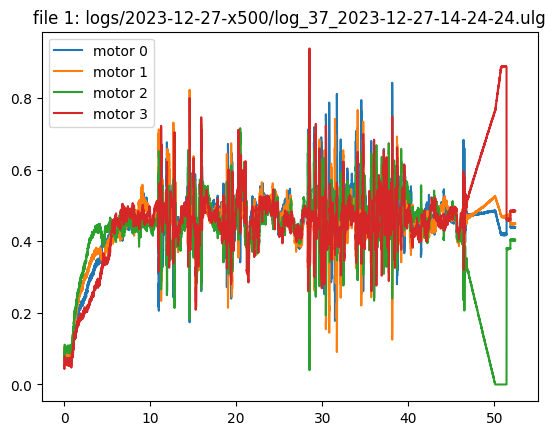

In [5]:
for i, (file, df) in enumerate(zip(ulog_files, dfs)):
    plt.figure()
    plt.title(f"file {i}: {file}")
    for i in range(4):
        plt.plot(df[f"{output_topic}_control[{i}]"].dropna(), label=f"motor {i}")
    plt.legend()

In [6]:
if model_name == "x500":
    timeframes = [
        # (30, 50),
        # (15, 50),
        (30, 50),
        (10, 40),
    ]
else:
    timeframes = [
        (4, 10),
        (7, 11),
    ]
dfs = [timeframe(df, time_start, time_end) for df, (time_start, time_end) in zip(dfs, timeframes)]

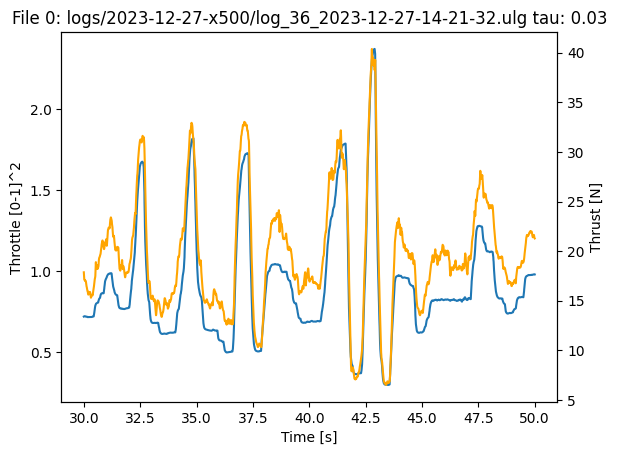

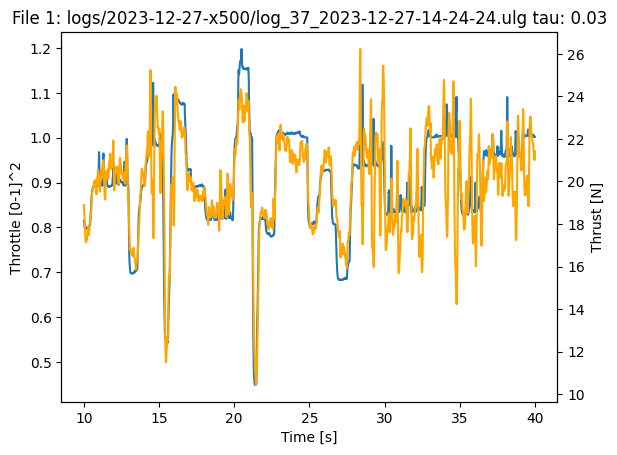

In [7]:
tau = 0.03
dfs_tt = [throttle_thrust(df, tau, model, output_topic) for df in dfs]
for i, (file, df) in enumerate(zip(ulog_files, dfs_tt)):
    plt.figure()
    plt.title(f"File {i}: {file} tau: {tau}")
    plt.plot(df["throttle"].dropna(), label="throttle")
    plt.ylabel("Throttle [0-1]^2")
    plt.xlabel("Time [s]")
    plt.twinx()
    plt.plot(df["thrust"].dropna(), label="acceleration", color="orange")
    plt.ylabel("Thrust [N]")
    plt.show()

100%|██████████| 100/100 [00:04<00:00, 23.71it/s]


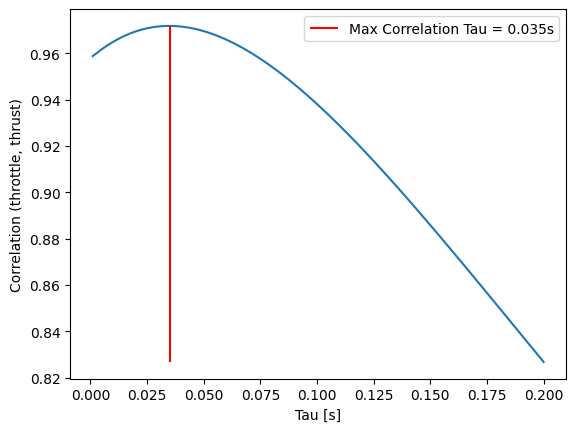

In [8]:
# throttle_estimation_files = list(range(len(ulog_files)))
throttle_estimation_files = [0]
tau_correlations = find_tau([dfs[i] for i in throttle_estimation_files], model, output_topic)
tau_argmax = tau_correlations[:, 1].argmax()
tau_max = tau_correlations[tau_argmax, 0]
plt.plot(tau_correlations[:, 0], tau_correlations[:, 1])
plt.vlines(tau_max, tau_correlations[:, 1].min(), tau_correlations[:, 1].max(), color="red", label=f"Max Correlation Tau = {tau_max:.3f}s")
plt.xlabel("Tau [s]")
plt.ylabel("Correlation (throttle, thrust)")
plt.legend()
plt.show()

In [9]:
dfs_tt = [throttle_thrust(df, tau_max, model, output_topic) for df in [dfs[i] for i in throttle_estimation_files]]

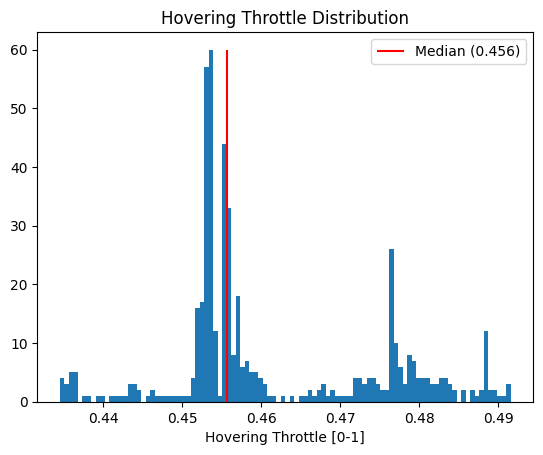

Hovering throttle: 0.45565179014316143 (per motor)


In [10]:
percentile = 0.05

df_tt = pd.concat(dfs_tt)
df_sysid = df_tt[["thrust", "throttle"]].dropna()
thrust = df_sysid["thrust"]
throttle = df_sysid["throttle"]

acceleration = thrust / model.mass
real_acceleration = (acceleration - model.gravity).abs()
real_acceleration_percentile = real_acceleration.quantile(percentile)
hovering_throttles = (throttle[real_acceleration < real_acceleration_percentile]/4) ** 0.5
hovering_throttle = hovering_throttles.median()
plt.title("Hovering Throttle Distribution")
counts, bin_edges, patches = plt.hist(hovering_throttles, bins=100)
plt.vlines(hovering_throttle, 0, max(counts), color="red", label=f"Median ({hovering_throttle:.3f})")
plt.xlabel("Hovering Throttle [0-1]")
plt.legend()
plt.show()
print(f"Hovering throttle: {hovering_throttle} (per motor)")

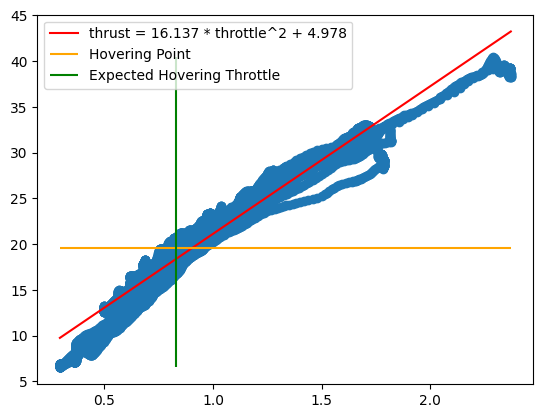

In [11]:

correlation, (slope, intercept) = fit_tau(dfs_tt, tau_max, model, output_topic)
plot_thrust_curve(df_tt, model, output_topic, tau_max, slope, intercept, hovering_throttle)

Correlation: 0.7803420357759929


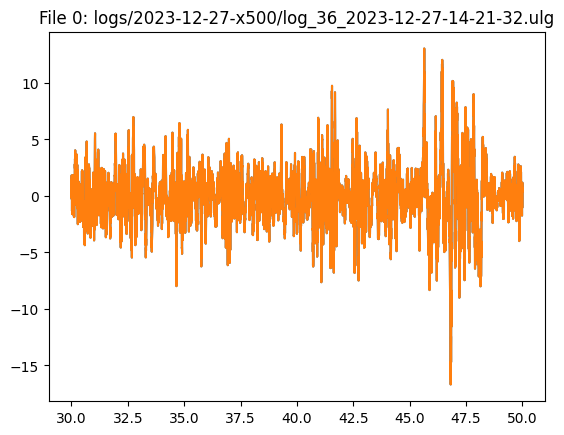

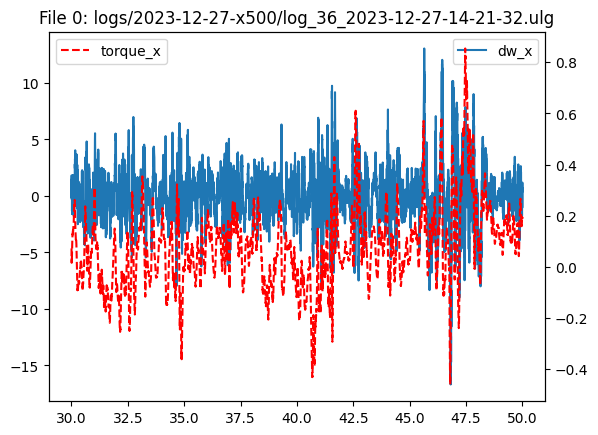

<Figure size 640x480 with 0 Axes>

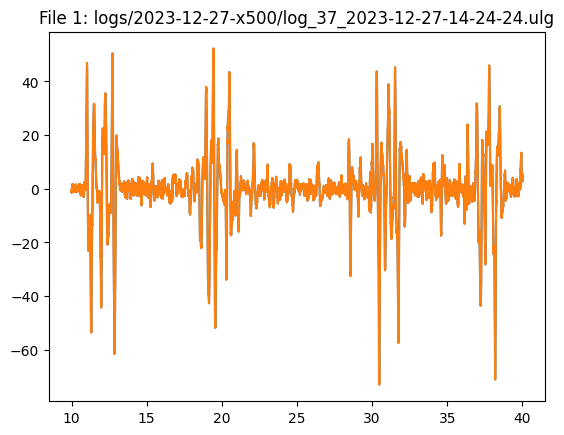

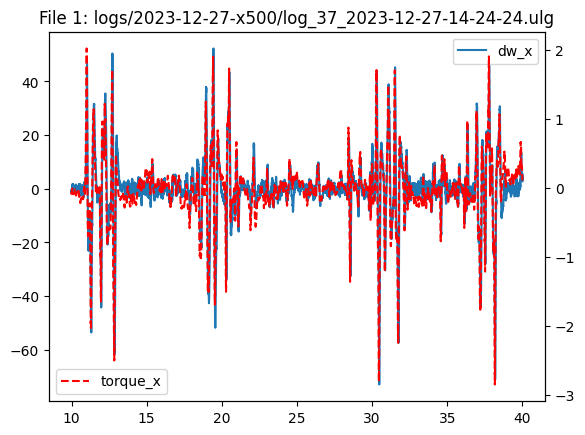

<Figure size 640x480 with 0 Axes>

In [12]:
dfs_tac = [torque_angular_acceleration(df, model, output_topic, tau, slope, intercept) for df in dfs]
df_tac = pd.concat(dfs_tac)
tac_correlation = df_tac["torque_x"].corr(df_tac["dw_x"])
print(f"Correlation: {tac_correlation}")
for i, (file, df_tt_tac) in enumerate(zip(ulog_files, dfs_tac)):

    plt.figure()
    plt.title(f"File {i}: {file}")
    plt.plot(df_tt_tac["vehicle_angular_velocity_xyz_derivative[0]"].dropna(), label="vehicle_angular_velocity_xyz_derivative[0]")
    plt.plot(df_tt_tac["dw_x"].dropna(), label="dw_x")
    plt.show()

    plt.figure()
    plt.title(f"File {i}: {file}")
    plt.plot(df_tt_tac["dw_x"].dropna(), label="dw_x")
    plt.legend()
    plt.twinx()
    plt.plot(df_tt_tac["torque_x"].dropna(), label="torque_x", color="red", linestyle="--")
    plt.legend()
    plt.show()
    plt.figure()

Correlation x 0.8586328043222493
Correlation y 0.8427676711616265


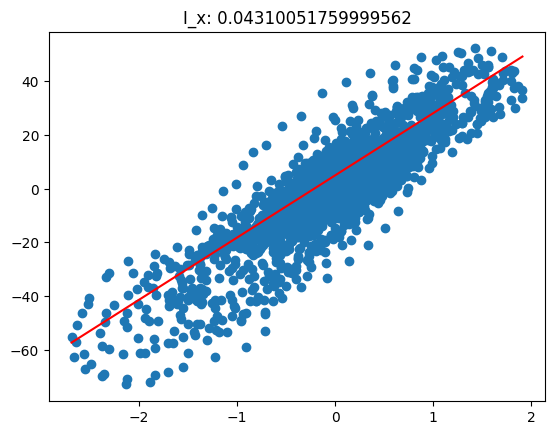

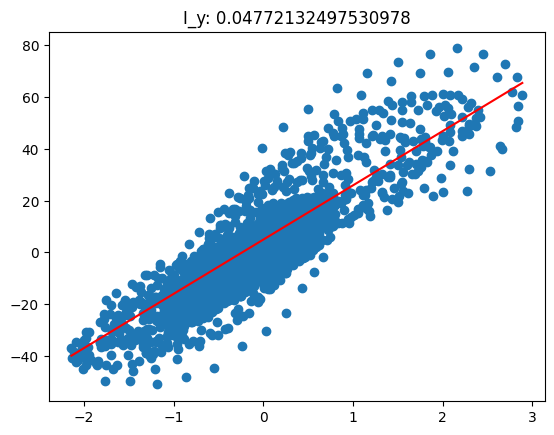

In [13]:
# angular_acceleration_files = list(range(len(ulog_files)))
inertia_estimation_files = [1] 
plot_torque_angular_acceleration_curve([dfs[i] for i in inertia_estimation_files], model, output_topic, tau_max, slope, intercept)